### Importing Necessary Packages

In [25]:
import pandas as pd
import numpy as np
from transformers import pipeline,AutoTokenizer,AutoModelForSequenceClassification,TrainingArguments, Trainer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import torch
from wordcloud import WordCloud, STOPWORDS
import warnings
from sklearn.metrics import classification_report
from datasets import Dataset,load_dataset
import re

### Upload dataset

In [26]:
# Original Dataset review
original_df_train = pd.read_csv('./train.csv')
original_df_test = pd.read_csv('./test.csv')

In [27]:
original_df_train


,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^
0,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
1,2,Amazing!,This soundtrack is my favorite music of all ti...
2,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
3,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."
4,2,an absolute masterpiece,I am quite sure any of you actually taking the...
...,...,...,...
3599994,1,Don't do it!!,The high chair looks great when it first comes...
3599995,1,"Looks nice, low functionality",I have used this highchair for 2 kids now and ...
3599996,1,"compact, but hard to clean","We have a small house, and really wanted two o..."
3599997,1,what is it saying?,not sure what this book is supposed to be. It ...


### Data Preprocessing Step

In [28]:
# The first line has been made into a heading for readability.
train_df = pd.read_csv('./train.csv', header=None, names=['labels', 'title', 'text'])
test_df = pd.read_csv('./test.csv', header=None, names=['labels', 'title', 'text'])

In [29]:
train_df

,labels,title,text
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."
...,...,...,...
3599995,1,Don't do it!!,The high chair looks great when it first comes...
3599996,1,"Looks nice, low functionality",I have used this highchair for 2 kids now and ...
3599997,1,"compact, but hard to clean","We have a small house, and really wanted two o..."
3599998,1,what is it saying?,not sure what this book is supposed to be. It ...


In [30]:
train_df = train_df.drop(columns=['title'])
test_df = test_df.drop(columns=['title'])

In [31]:
train_df


,labels,text
0,2,This sound track was beautiful! It paints the ...
1,2,I'm reading a lot of reviews saying that this ...
2,2,This soundtrack is my favorite music of all ti...
3,2,I truly like this soundtrack and I enjoy video...
4,2,"If you've played the game, you know how divine..."
...,...,...
3599995,1,The high chair looks great when it first comes...
3599996,1,I have used this highchair for 2 kids now and ...
3599997,1,"We have a small house, and really wanted two o..."
3599998,1,not sure what this book is supposed to be. It ...


In [32]:
train_df['labels'] = train_df['labels'].map({1: 0, 2: 1})
test_df['labels'] = test_df['labels'].map({1: 0, 2: 1})

In [33]:
train_df

,labels,text
0,1,This sound track was beautiful! It paints the ...
1,1,I'm reading a lot of reviews saying that this ...
2,1,This soundtrack is my favorite music of all ti...
3,1,I truly like this soundtrack and I enjoy video...
4,1,"If you've played the game, you know how divine..."
...,...,...
3599995,0,The high chair looks great when it first comes...
3599996,0,I have used this highchair for 2 kids now and ...
3599997,0,"We have a small house, and really wanted two o..."
3599998,0,not sure what this book is supposed to be. It ...


In [34]:
negatives_train = train_df[train_df["labels"] == 0]
positives_train = train_df[train_df["labels"] == 1]

negatives_test = test_df[test_df["labels"] == 0]
positives_test = test_df[test_df["labels"] == 1]

subset_size_train = 500_000
subset_size_test = 50_000
neg_samples_train = negatives_train.sample(n=subset_size_train, random_state=42)
pos_samples_train = positives_train.sample(n=subset_size_train, random_state=42)

neg_samples_test = negatives_test.sample(n=subset_size_test, random_state=42)
pos_samples_test = positives_test.sample(n=subset_size_test, random_state=42)

# New balanced dataset creation
balanced_df_train = pd.concat([neg_samples_train, pos_samples_train]).sample(frac=1, random_state=42)  # Shuffling
balanced_df_test = pd.concat([neg_samples_test,pos_samples_test]).sample(frac=1,random_state=42)
# Results of creation new dataset
print(balanced_df_train["labels"].value_counts())  # 500K negative, 500K positive 
print(f"New train dataset size: {len(balanced_df_train)}")  # 1M totally
print(balanced_df_test["labels"].value_counts()) # 50K negative and 50K positive
print(f"New test dataset size:{len(balanced_df_test)}") # 100K totally

labels
1    500000
0    500000
Name: count, dtype: int64
New train dataset size: 1000000
labels
1    50000
0    50000
Name: count, dtype: int64
New test dataset size:100000


In [35]:
import re

def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # removing URL
    text = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", text)  # cleaning special character
    text = re.sub(r"\s{2,}", " ", text)  # remove extra space
    return text.strip()

In [36]:
balanced_df_train['text'] = balanced_df_train['text'].apply(clean_text)
balanced_df_test['text'] = balanced_df_test['text'].apply(clean_text)

In [37]:
print(balanced_df_train.isnull().sum())  # Checking for null value
print(balanced_df_train.describe())

labels    0
text      0
dtype: int64
          labels
count  1000000.0
mean         0.5
std          0.5
min          0.0
25%          0.0
50%          0.5
75%          1.0
max          1.0


In [38]:
balanced_df_train = balanced_df_train[balanced_df_train['text'].str.strip() != '']
balanced_df_test = balanced_df_test[balanced_df_test['text'].str.strip() != '']

In [39]:
balanced_df_train['text'].iloc[10]

"Thinking I needed a fast memory card for continuous shooting on my Canon A710 digital camera, I bought the Promax 512MB Sd 150X memory card On day one I took about 30 pictures before I received a memory card error I lost all the pictures and could not retreive tham on my camera or computer I then put in my normal speed Sd card and could still shoot on continuous mode without problems Maybe fast isn't necessary, especially if it isn't reliable"

In [40]:
train_dataset = Dataset.from_pandas(balanced_df_train)
test_dataset = Dataset.from_pandas(balanced_df_test)

print(train_dataset)

Dataset({
    features: ['labels', 'text', '__index_level_0__'],
    num_rows: 999998
})


### Tokenization and Training

In [41]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

In [42]:
# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', max_length=512, truncation=True,return_tensors="pt")

# Tokenizing datasets
train_tokenized = train_dataset.map(tokenize_function, batched=True)
test_tokenized = test_dataset.map(tokenize_function, batched=True)

# Ex: tokenized test format printing
print(test_tokenized)

Map: 100%|██████████| 100000/100000 [00:18<00:00, 5358.44 examples/s]

Dataset({
    features: ['labels', 'text', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 100000
})


In [19]:
train_tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Ex: test tokenized with torch formatting
print(test_tokenized)

Dataset({
    features: ['labels', 'text', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 100000
})


#### Uploading distilbert base uncased model for training

In [20]:

#model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased',torch_dtype=torch.float16, attn_implementation="sdpa" ,num_labels=2)

#import torch

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", 
    torch_dtype=torch.bfloat16,  # FP16 instead of FP32
    attn_implementation="sdpa",  # SDPA instead of "eager"
    num_labels=2
).to("cuda")

#model = torch.compile(model)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus: # so tf does not map all gpu space
	tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
from transformers import Trainer, TrainingArguments

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",  # Epoch evalution strategy instead of steps
    #eval_steps=50,
    learning_rate=2e-5, # 1e-5, 2e-6
    per_device_train_batch_size=64, # 256,512 
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    #weight_decay=0.0001, # 0.01 # decreasing training and eval loss accuracy
    report_to="none",
    bf16=True,
    fp16=False,
    logging_steps=200,
    gradient_accumulation_steps=4, # simulation of 64 x 4 batch size 
    save_total_limit=1,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    #fp16_opt_level="O2",
)

# Creating of trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    tokenizer=tokenizer,
)

# Model Training
trainer.train()

In [ ]:
metrics = trainer.evaluate()
print(metrics)

In [ ]:
print(train_tokenized[0])

In [ ]:
#model.save_pretrained("./bert-finetuned-amazon-reviews")
#tokenizer.save_pretrained("./bert-finetuned-amazon-reviews")
trainer.save_model("./bert-finetuned-amazon-reviews_v4")
tokenizer.save_pretrained("./bert-finetuned-amazon-reviews_v4")

In [21]:

model_path = "./bert-finetuned-amazon-reviews_v4"

# Upload Model
model = AutoModelForSequenceClassification.from_pretrained(model_path).to("cuda")

# Upload Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)



### Calculation of Metrics

In [22]:
from torch.utils.data import DataLoader
from datasets import Dataset
import numpy as np
from tqdm import tqdm
#test_tokenized = test_tokenized.rename_columns({"label": "labels"})
testing_dataloader = DataLoader(test_tokenized, batch_size=128, shuffle=False)

model.eval()
preds = []
labels = []

with torch.no_grad():
    for batch in tqdm(testing_dataloader,desc="Prediction Progress",unit= "batch"):
        inputs = {k:v.to("cuda") for k,v in batch.items() if k != "labels"}
        outputs = model(**inputs)
        logits = outputs.logits
        predictions = torch.argmax(logits,dim=-1).cpu().numpy()

        preds.extend(predictions)
        labels.extend(batch["labels"].cpu().numpy())

preds = np.array(preds)
labels = np.array(labels)

Prediction Progress: 100%|██████████| 782/782 [09:59<00:00,  1.30batch/s]


Accuracy: 0.9205
Precision: 0.9218
Recall: 0.9190
F1 Score: 0.9204


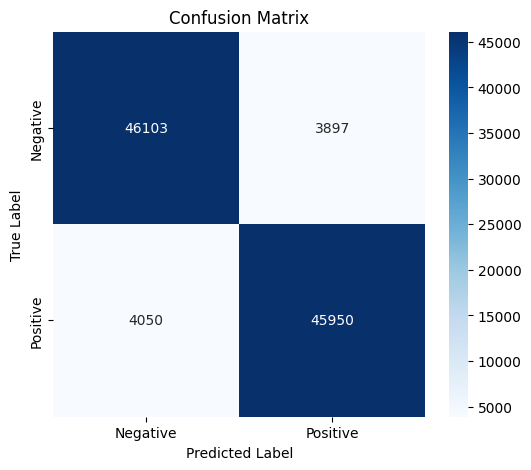

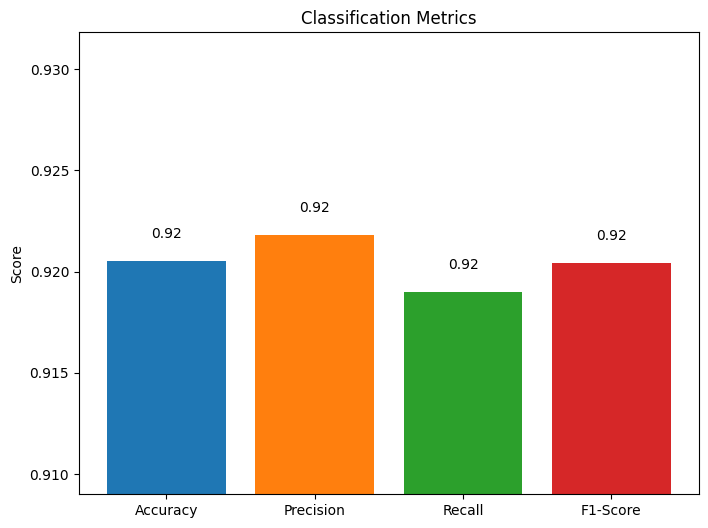

In [24]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
# Accuracy 
accuracy = accuracy_score(labels, preds)

# Precision, Recall, F1-score(average="binary" for 2 class )
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")

# Confusion Matrix 
conf_matrix = confusion_matrix(labels, preds)

# Results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# 📌 **Confusion Matrix Visualization**
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# 📌 **Precision - Recall - F1 Score Bar Chart**
#metrics = {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 Score": f1}
metrics = {
    "Accuracy" : accuracy,
    "Precision": precision,
    "Recall"   : recall,
    "F1-Score" : f1
}

# Dinamik y-ekseni aralığı: en düşük değerin hemen altından en yüksek değerin biraz üstüne
values = list(metrics.values())
min_val, max_val = min(values), max(values)
margin = 0.01  # %5 marjin
ymin = max(min_val - margin, 0)
ymax = min(max_val + margin, 1.0)

# Renk paleti (4 farklı renk)
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

plt.figure(figsize=(8,6))
bars = plt.bar(metrics.keys(), metrics.values(), color=colors)
plt.ylim(ymin, ymax)
plt.ylabel("Score")
plt.title("Classification Metrics")

# Her bar'ın tepesine değer ekleyelim
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.001,
        f"{height:.2f}",
        ha="center",
        va="bottom"
    )
plt.show()


### Manuel Testing 

In [ ]:
test_sentence = ["ı am happy to share this notebook"]
inputs = tokenizer(test_sentence, padding=True, truncation=True, return_tensors="pt", max_length=512).to("cuda")
with torch.no_grad():
    output_of_manuel = model(**inputs)

predictions_of_manuel = torch.argmax(output_of_manuel.logits,dim=-1)

for sentence,prediction_of_manuel in zip(test_sentence,predictions_of_manuel):
    sentiment = "Positive" if prediction_of_manuel.item() == 1 else "Negative"
    print(f"Sentence: '{sentence}' => Sentiment: {sentiment}")